In [1]:
from visual_behavior.visualization.qc import session_plots as sp
from visual_behavior.visualization.qc import container_plots as cp
from visual_behavior.visualization.qc import data_loading as dl
import visual_behavior.utilities as vbu
import matplotlib.pyplot as plt
import pandas as pd

from visual_behavior.translator.foraging2 import data_to_change_detection_core
from visual_behavior.translator.core import create_extended_dataframe
from visual_behavior.change_detection.trials import summarize
import visual_behavior.database as db

import plotly.graph_objects as go
import plotly.express as px

import xarray as xr

%matplotlib inline

/home/dougo/.local/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home/dougo/Code/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_api/behavior_ophys_nwb_api.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%widescreen

In [3]:
def load_data():
    container_df = dl.build_container_df()
    filtered_container_list = dl.get_filtered_ophys_container_ids()  # NOQA F841
    return container_df.query('container_id in @filtered_container_list')

In [4]:
container_df = load_data()
container_df['line'] = container_df['driver_line'].map(lambda s:';'.join(s))
session_summary = db.get_behavior_session_summary()

In [5]:
container_df

,container_id,container_workflow_state,first_acquistion_date,project_code,driver_line,targeted_structure,imaging_depth,equipment_name,specimen_id,sex,age_in_days,session_0,session_1,session_2,session_3,session_4,session_5,line
0,991913453,completed,2019-12-11,VisualBehaviorTask1B,[Sst-IRES-Cre],VISp,275,[CAM2P.4],910267443,M,194.0,OPHYS_1_images_B 993862620,OPHYS_2_images_B_passive 994053903,OPHYS_3_images_B 994790561,OPHYS_4_images_A 995280513,OPHYS_6_images_A 995439942,OPHYS_5_images_A_passive 995622557,Sst-IRES-Cre
1,989461845,completed,2019-12-04,VisualBehaviorTask1B,[Sst-IRES-Cre],VISp,275,[CAM2P.3],940744053,M,143.0,OPHYS_1_images_B 992296756,OPHYS_2_images_B_passive 992572516,OPHYS_3_images_B 992870927,OPHYS_4_images_A 993344860,OPHYS_5_images_A_passive 993593393,OPHYS_6_images_A 993864050,Sst-IRES-Cre
2,978206330,container_qc,2019-11-14,VisualBehaviorTask1B,[Sst-IRES-Cre],VISp,275,[CAM2P.3],916452082,M,148.0,OPHYS_1_images_B 982862443,OPHYS_2_images_B_passive 984551228,OPHYS_3_images_B 986402309,OPHYS_4_images_A 989191384,OPHYS_6_images_A 989594023,OPHYS_5_images_A_passive 990381322,Sst-IRES-Cre
8,969421516,container_qc,2019-10-03,VisualBehaviorTask1B,[Vip-IRES-Cre],VISp,175,[CAM2P.3],887127198,M,170.0,OPHYS_1_images_B 960953590,OPHYS_3_images_B 962473308,OPHYS_2_images_B_passive 963394081,OPHYS_4_images_A 964440177,OPHYS_5_images_A_passive 965228771,OPHYS_6_images_A 965928394,Vip-IRES-Cre
3,968451510,container_qc,2019-10-24,VisualBehavior,"[Camk2a-tTA, Slc17a7-IRES2-Cre]",VISp,175,[CAM2P.5],916458892,F,135.0,OPHYS_1_images_A 972701564,OPHYS_2_images_A_passive 973927944,OPHYS_3_images_A 974384470,OPHYS_4_images_B 974945686,OPHYS_6_images_B 977132456,OPHYS_5_images_B_passive 977937585,Camk2a-tTA;Slc17a7-IRES2-Cre
4,957570596,container_qc,2019-10-10,VisualBehaviorTask1B,[Vip-IRES-Cre],VISp,175,[CAM2P.4],880255046,M,177.0,OPHYS_1_images_B 965224600,OPHYS_2_images_B_passive 967008454,OPHYS_3_images_B 967876201,OPHYS_4_images_A 968651977,OPHYS_5_images_A_passive 969809655,OPHYS_6_images_A 972200901,Vip-IRES-Cre
6,957366099,container_qc,2019-10-08,VisualBehaviorTask1B,"[Camk2a-tTA, Slc17a7-IRES2-Cre]",VISp,375,[CAM2P.3],912556133,F,131.0,OPHYS_1_images_B 963394065,OPHYS_2_images_B_passive 964955813,OPHYS_3_images_B 965231035,OPHYS_4_images_A 967007328,OPHYS_5_images_A_passive 967877560,NaN,Camk2a-tTA;Slc17a7-IRES2-Cre
5,957361481,container_qc,2019-10-08,VisualBehaviorTask1B,"[Camk2a-tTA, Slc17a7-IRES2-Cre]",VISp,375,[CAM2P.4],916634005,M,118.0,OPHYS_1_images_B 963391867,OPHYS_2_images_B_passive 964422360,OPHYS_3_images_B 965218519,OPHYS_4_images_A 967008471,OPHYS_5_images_A_passive 967876219,OPHYS_6_images_A 968651957,Camk2a-tTA;Slc17a7-IRES2-Cre
7,957024596,container_qc,2019-10-04,VisualBehavior,[Sst-IRES-Cre],VISp,290,[CAM2P.5],882757053,M,174.0,OPHYS_2_images_A_passive 961283857,OPHYS_3_images_A 962471831,OPHYS_4_images_B 965228792,OPHYS_5_images_B_passive 965930965,OPHYS_6_images_B 967005387,NaN,Sst-IRES-Cre
9,947838486,container_qc,2019-09-24,VisualBehaviorTask1B,"[Camk2a-tTA, Slc17a7-IRES2-Cre]",VISp,175,[CAM2P.5],912554454,F,119.0,OPHYS_1_images_B 958435363,OPHYS_3_images_B 956903412,OPHYS_2_images_B_passive 960351943,OPHYS_4_images_A 963397268,OPHYS_5_images_A_passive 964460159,OPHYS_6_images_A 965218395,Camk2a-tTA;Slc17a7-IRES2-Cre


In [6]:
container_df = container_df.sort_values(by=['line','targeted_structure','first_acquistion_date'])
container_ids = container_df.container_id.values
sessions = ['session_{}'.format(i) for i in range(6)]

In [7]:
session_prefixes = []
for container_id in container_ids:
    session_prefixes += [s.split(' ')[0][:7] for s in container_df[container_df['container_id']==container_id][sessions].values[0] if pd.notnull(s)]
session_prefixes = np.sort(np.unique(np.array(session_prefixes)))
session_prefixes

array(['OPHYS_1', 'OPHYS_2', 'OPHYS_3', 'OPHYS_4', 'OPHYS_5', 'OPHYS_6'],
      dtype='<U7')

In [8]:
values = ['d_prime_peak','number_of_licks','num_contingent_trials']
val_array = xr.DataArray(
    np.zeros((len(container_ids), len(sessions),len(values))), 
    dims=('container_id', 'session_prefix','value'), 
    coords={'container_id':container_ids, 'session_prefix':session_prefixes,'value':values}
)*np.nan

In [9]:
vb = db.Database('visual_behavior_data')

In [10]:
def get_movie_filepath(osid):
    well_known_files = db.get_well_known_files(osid).set_index('name')
    behavior_video_path = ''.join(well_known_files.loc['RawBehaviorTrackingVideo'][[
                                  'storage_directory', 'filename']].tolist())
    return behavior_video_path

In [11]:
def oeid_to_uuid(oeid):
    return db.convert_id({'ophys_experiment_id':oeid},'behavior_session_uuid')

def get_oeid(container_id,session_number):
    entry_string = container_df.query('container_id == @container_id')['session_{}'.format(session_number)].iloc[0]
    if pd.notnull(entry_string):
        return int(entry_string.split(' ')[1])
        
def get_uuid(container_id, session_number):
    oeid = get_oeid(container_id, session_number)
    if pd.notnull(oeid):
        return oeid_to_uuid(oeid)
    else:
        return None

def get_session_stats(container_id,session_number):
    vb = db.Database('visual_behavior_data')
    behavior_session_uuid = get_uuid(container_id,session_number)
    stats = vb.behavior_data['summary'].find_one({'behavior_session_uuid':behavior_session_uuid})
    vb.close()
    return stats

def get_value(container_id, session_number, value):
    behavior_session_uuid = get_uuid(container_id,session_number)
    session_stats = get_session_stats(container_id,session_number)
    if value == 'session_prefix':
        oeid = get_oeid(container_id,session_number)
        return dl.get_session_type_for_ophys_experiment_id(oeid)[:7]
    elif value == 'ophys_experiment_id' or value == 'ophys_session_id':
        return db.convert_id({'behavior_session_uuid': behavior_session_uuid},value)
    else:
        return session_stats[value]
    
def rewrite_record(uuid):
    pkl_path = db.get_pkl_path(uuid)
    data = pd.read_pickle(pkl_path)
    
    core_data = data_to_change_detection_core(data)
    trials = create_extended_dataframe(**core_data).drop(columns=['date', 'LDT_mode'])
    summary = summarize.session_level_summary(trials).iloc[0].to_dict()
    summary.update({'error_on_load':0})
    db.update_or_create(
        vb['behavior_data']['summary'],
        db.simplify_entry(summary),
        ['behavior_session_uuid'],
        force_write=False
    )

In [12]:
for container_id in container_ids:
    for session_number in range(6):
        bs_uuid = get_uuid(container_id, session_number)
        if pd.notnull(bs_uuid):
            session_stats = get_session_stats(container_id, session_number)
            if 'error_on_load' in session_stats.keys() and session_stats['error_on_load'] == 1:
                rewrite_record(bs_uuid)
            session_prefix = get_value(container_id, session_number, 'session_prefix')
            
            for value in values:
                v = get_value(container_id, session_number, value)
                val_array.loc[{'container_id':container_id, 'session_prefix':session_prefix,'value':value}] = v

In [13]:
container_id = 814797528
get_session_stats(container_id,1)

{'_id': ObjectId('5d5e4428eeab8349b6f745a5'),
 'mouse_id': '421136',
 'behavior_session_uuid': 'fa385ba2-3c2c-4f88-988f-90151629e9f7',
 'startdatetime': datetime.datetime(2019, 1, 8, 16, 43, 52, 128000),
 'session_duration': 3601.330871177301,
 'd_prime_peak': 1.7368920761910625,
 'discrim_p': 0.16977817679240736,
 'response_bias': 0.38333333333333336,
 'earned_water': 0.448,
 'total_water': 0.448,
 'num_contingent_trials': 180,
 'lick_latency_median': 0.47540438038413413,
 'fraction_time_aborted': 0.5755454596558418,
 'fraction_time_hit': 0.1442337230701007,
 'fraction_time_miss': 0.22727454207957443,
 'fraction_time_correct_reject': 0.04231610702752629,
 'fraction_time_false_alarm': 0.010630168166956888,
 'fraction_time_auto_rewarded': 0.0,
 'number_of_hit_trials': 64,
 'number_of_miss_trials': 94,
 'number_of_false_alarm_trials': 5,
 'number_of_correct_reject_trials': 17,
 'hit_rate': 0.4050632911392405,
 'false_alarm_rate': 0.22727272727272727,
 'hit_rate_peak': 0.9104477611940298,

In [14]:
container_id = container_ids[9]

In [15]:
# label = ['CID = {}, line = {}, depth = {}'.format(cid,line,depth) for ]

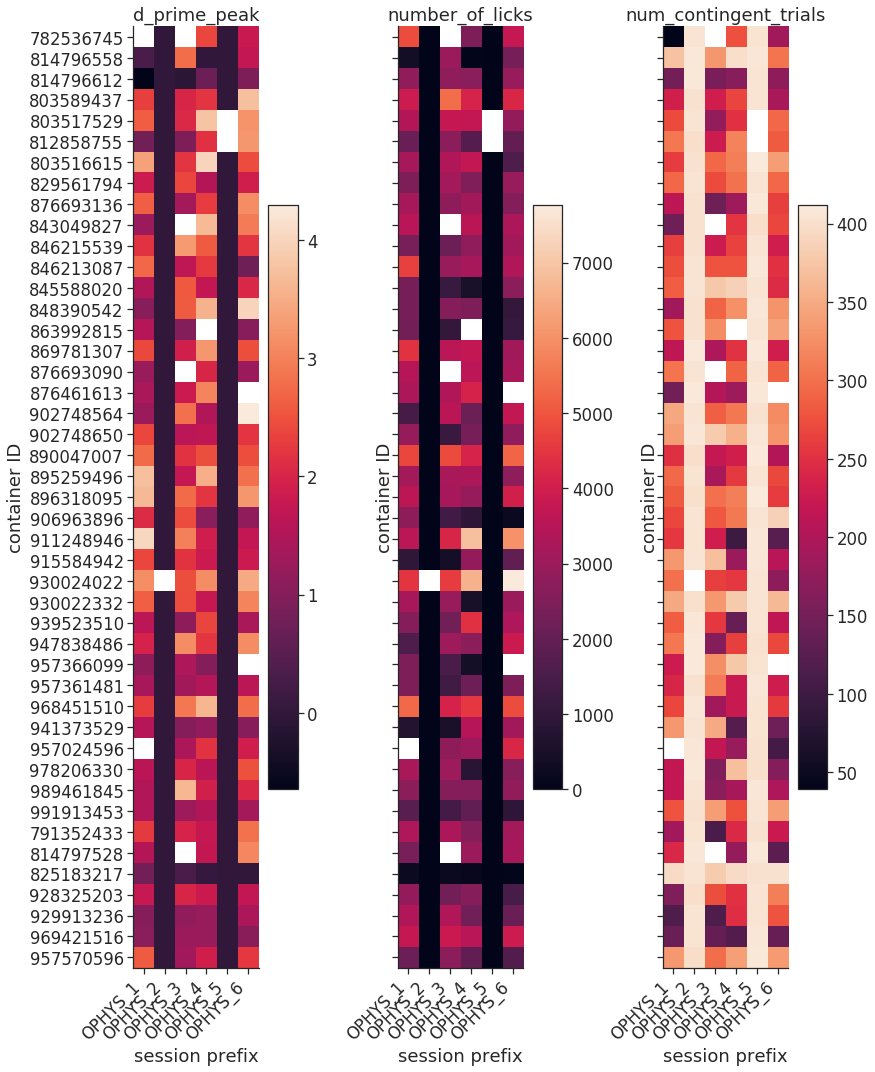

In [16]:
fig,ax=plt.subplots(1,3,figsize=(12,15),sharey=True,facecolor='white')
for ii,value in enumerate(values):
    im = ax[ii].imshow(val_array.loc[{'container_id':container_ids,'value':value}].values)
    ax[ii].set_yticks(np.arange(len(container_ids)));
    ax[ii].set_yticklabels(container_ids);
    ax[ii].set_xticks(np.arange(6))
    ax[ii].set_xticklabels(session_prefixes,rotation=45,ha='right')
    ax[ii].set_ylabel('container ID')
    ax[ii].set_xlabel('session prefix')

    fig.colorbar(im, ax=ax[ii])
    ax[ii].set_title('{}'.format(value))
fig.tight_layout()
fig.savefig('/home/dougo/dropbox/temp_fig.png',dpi=150)

In [17]:
len([str(c) for c in container_ids])

45

In [28]:
value = 'd_prime_peak'
for value in values:
    fig = go.Figure(
        data=go.Heatmap(
            z=val_array.loc[{'container_id':container_ids,'value':value}].values,
            x=session_prefixes,
    #         y = [str(i) for i in range(len(container_ids))],
            y=container_ids,
            hoverongaps = True,
            colorbar={'title':value},
            colorscale='viridis',
        )
    )

    fig.update_layout(
        autosize=False,
        width=700,
        height=20*len(container_ids),
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=50,
            pad=0
        ),
        xaxis_title='ophys session',
        yaxis_title='container ID',
        title='{} by container ID and ophys session'.format(value)
    )
    fig.update_yaxes(autorange="reversed",type='category',dtick=1)
    fig.update_xaxes(dtick=1)
    fig.write_html("/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/qc_plots/overview_plots/{}_container_overview.html".format(value))
fig.show()

In [20]:
container_id = container_ids[0]
get_session_stats(container_id,0)

{'_id': ObjectId('5e744198116a11a02dec5881'),
 'mouse_id': '403491',
 'behavior_session_uuid': '7da1aebf-fad4-4013-a991-18a13d1a8b94',
 'startdatetime': datetime.datetime(2018, 11, 8, 19, 22, 6, 936000),
 'session_duration': 3593.4077284647865,
 'd_prime_peak': nan,
 'discrim_p': 0.8398822850603558,
 'response_bias': 0.8717948717948718,
 'flashwise_lick_probability': 0.29809550096605025,
 'earned_water': 0.203,
 'total_water': 0.203,
 'num_contingent_trials': 39,
 'lick_latency_median': 0.4002853433485143,
 'fraction_time_aborted': 0.9113092281090072,
 'fraction_time_hit': 0.0656899986096539,
 'fraction_time_miss': 0.01234722586789854,
 'fraction_time_correct_reject': 0.0,
 'fraction_time_false_alarm': 0.010653547413440313,
 'fraction_time_auto_rewarded': 0.0,
 'number_of_hit_trials': 29,
 'number_of_miss_trials': 5,
 'number_of_false_alarm_trials': 5,
 'number_of_correct_reject_trials': 0.0,
 'hit_rate_peak': nan,
 'false_alarm_rate_peak': nan,
 'number_of_licks': 4874,
 'blank_durati

In [21]:
uuid = '7da1aebf-fad4-4013-a991-18a13d1a8b94'
pkl_path = db.get_pkl_path(uuid)
data = pd.read_pickle(pkl_path)

core_data = data_to_change_detection_core(data)
trials = create_extended_dataframe(**core_data).drop(columns=['date', 'LDT_mode'])
summary = summarize.session_level_summary(trials).iloc[0].to_dict()

In [18]:
summary

{'mouse_id': '403491',
 'behavior_session_uuid': UUID('7da1aebf-fad4-4013-a991-18a13d1a8b94'),
 'startdatetime': Timestamp('2018-11-08 11:22:06.936000-0800', tz='tzoffset(None, -28800)'),
 'session_duration': 3593.4077284647865,
 'd_prime_peak': nan,
 'discrim_p': 0.8398822850603558,
 'response_bias': 0.8717948717948718,
 'flashwise_lick_probability': 0.29809550096605025,
 'earned_water': 0.203,
 'total_water': 0.203,
 'num_contingent_trials': 39,
 'lick_latency_median': 0.4002853433485143,
 'fraction_time_aborted': 0.9113092281090072,
 'fraction_time_hit': 0.0656899986096539,
 'fraction_time_miss': 0.01234722586789854,
 'fraction_time_correct_reject': 0.0,
 'fraction_time_false_alarm': 0.010653547413440313,
 'fraction_time_auto_rewarded': 0.0,
 'number_of_hit_trials': 29,
 'number_of_miss_trials': 5,
 'number_of_false_alarm_trials': 5,
 'number_of_correct_reject_trials': 0.0,
 'hit_rate_peak': nan,
 'false_alarm_rate_peak': nan,
 'number_of_licks': 4874,
 'blank_duration': 0.5,
 'day_

In [20]:
from visual_behavior.change_detection.trials import session_metrics

In [26]:
session_metrics.peak_dprime(trials)

AssertionError: 

In [27]:
%debug

> /home/dougo/Code/visual_behavior_analysis/visual_behavior/change_detection/trials/session_metrics.py(151)peak_dprime()
    149         apply_trial_number_limit=apply_trial_number_limit
    150     )
--> 151     assert False
    152     if np.all(np.isnan(dp)):
    153         return np.nan

ipdb> dp
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan, -1.76039905, -2.00770851, -1.89562057,
       -1.80194736, -1.72176253, -1.89562057, -1.82394565, -1.82394565,
       -1.76039905, -1.70342215, -1.70342215, -1.83757146, -1.83757146,
       -1.78495279, -1.73689208, -1.69270787, -1.65185812, -1.61390484,
       -1.57848928, -1.54531406, -1.51413007, -1.48472664, -1.4569241 ,
       -1.4569241 , -1.43056806, -1.4055249 , -1.38167828, -1.35892631,
       -1.33717925, -1.3163577 , -1.29639111, -1.27721648])
ipdb> np.all(np.isnan(dp)
*** SyntaxError: unexpected EOF while parsing
ipdb> np.all(np.isnan(dp))
False
ipdb> len(dp)
39
ipdb> q


In [25]:
nonaborted_trials = trials.query('trial_type != "aborted"')
_,_,dp = vbu.get_response_rates(nonaborted_trials)
dp

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan, -1.76039905, -2.00770851, -1.89562057,
       -1.80194736, -1.72176253, -1.89562057, -1.82394565, -1.82394565,
       -1.76039905, -1.70342215, -1.70342215, -1.83757146, -1.83757146,
       -1.78495279, -1.73689208, -1.69270787, -1.65185812, -1.61390484,
       -1.57848928, -1.54531406, -1.51413007, -1.48472664, -1.4569241 ,
       -1.4569241 , -1.43056806, -1.4055249 , -1.38167828, -1.35892631,
       -1.33717925, -1.3163577 , -1.29639111, -1.27721648])

In [115]:
db.convert_id({'ophys_experiment_id':775614751},'ophys_session_id')

775289198

In [132]:
db.get_well_known_files(db.convert_id({'ophys_experiment_id':775614751},'ophys_session_id')).iloc[0]['storage_directory']

'/allen/programs/braintv/production/visualbehavior/prod0/specimen_722884882/ophys_session_775289198/eye_tracking/'

In [121]:
m = vbu.Movie(get_movie_filepath(db.convert_id({'ophys_experiment_id':775614751},'ophys_session_id')))

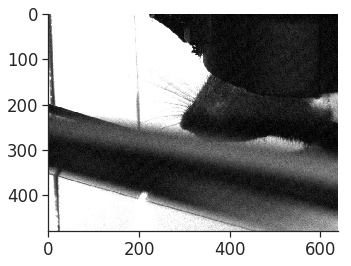

In [129]:
fig,ax=plt.subplots()
ax.imshow(m.get_frame(6010))

In [80]:
fig = go.Figure()
z2 = val_array.loc[{'value':'number_of_licks'}].values
z3 = val_array.loc[{'value':'number_of_licks'}].values
fig.add_trace(
    go.Heatmap(
        x=session_prefixes,
#         y=container_ids,
        z=val_array.loc[{'value':'d_prime_peak'}].values,
        customdata=np.dstack((z2, z3)),
        hovertemplate='<b>d_prime_peak:%{z:.3f}</b><br>number_of_licks:%{customdata[0]:.3f} <br> ',
#         coloraxis="coloraxis1", name=''
    )
)
fig.update_yaxes(autorange="reversed")
fig.show()

In [58]:
len(container_ids)

43

In [133]:
ophys_experiment_table = dl.get_filtered_ophys_experiment_table().sort_values(by='date_of_acquisition', ascending=False).reset_index()

In [134]:
len(ophys_experiment_table)

247

In [ ]:
def get_session_from_mongo(ophys_experiment_id):
    uuid = oeid_to_uuid(ophys_experiment_id)
    vb = db.Database('visual_behavior_data')
    stats = vb.behavior_data['summary'].find_one({'behavior_session_uuid':uuid})
    vb.close()
    return stats['stage']

def get_date_from_mongo(ophys_experiment_id):
    uuid = oeid_to_uuid(ophys_experiment_id)
    vb = db.Database('visual_behavior_data')
    stats = vb.behavior_data['summary'].find_one({'behavior_session_uuid':uuid})
    vb.close()
    return stats['startdatetime']
    

ophys_experiment_table['mongo_session_name'] = ophys_experiment_table['ophys_session_id'].map(lambda osid:get_session_from_mongo(osid))
ophys_experiment_table['mongo_date'] = ophys_experiment_table['ophys_session_id'].map(lambda osid:get_date_from_mongo(osid))
